## BERT Setup

In [440]:
# Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW ,  get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)


## Data Exploration

In [441]:
df = pd.read_csv('./Data.csv')

In [442]:
df.head()

,Unnamed: 0,Summary,Rate
0,0,the best poduct that i bought from flifkart it...,5
1,1,cooler is big and wide maharaja brand trust y ...,4
2,2,it is one of the best air coolers at reasonabl...,5
3,3,awesome air cooleri was looking for a cooler u...,5
4,4,purchased after a lot of discussions and revie...,5


In [443]:
df.shape

(685, 3)

In [444]:
df.info

<bound method DataFrame.info of      Unnamed: 0                                            Summary  Rate
0             0  the best poduct that i bought from flifkart it...     5
1             1  cooler is big and wide maharaja brand trust y ...     4
2             2  it is one of the best air coolers at reasonabl...     5
3             3  awesome air cooleri was looking for a cooler u...     5
4             4  purchased after a lot of discussions and revie...     5
..          ...                                                ...   ...
680         680    excellent product with excellent delivery speed     5
681         681                                               nice     5
682         682                      nice product on time delivery     4
683         683                                      super cooling     5
684         684                                    awesome product     5

[685 rows x 3 columns]>

In [445]:
# drop missing data
missing_data = df.isna()
missing_counts = missing_data.sum()
missing_counts

Unnamed: 0    0
Summary       0
Rate          0
dtype: int64

In [446]:
grouped_count = df.groupby(['Rate'])['Rate'].count()
grouped_count

Rate
1     57
2     11
3     16
4    189
5    412
Name: Rate, dtype: int64

#### Data Visualization - Review

Text(0.5, 0, 'Rate')

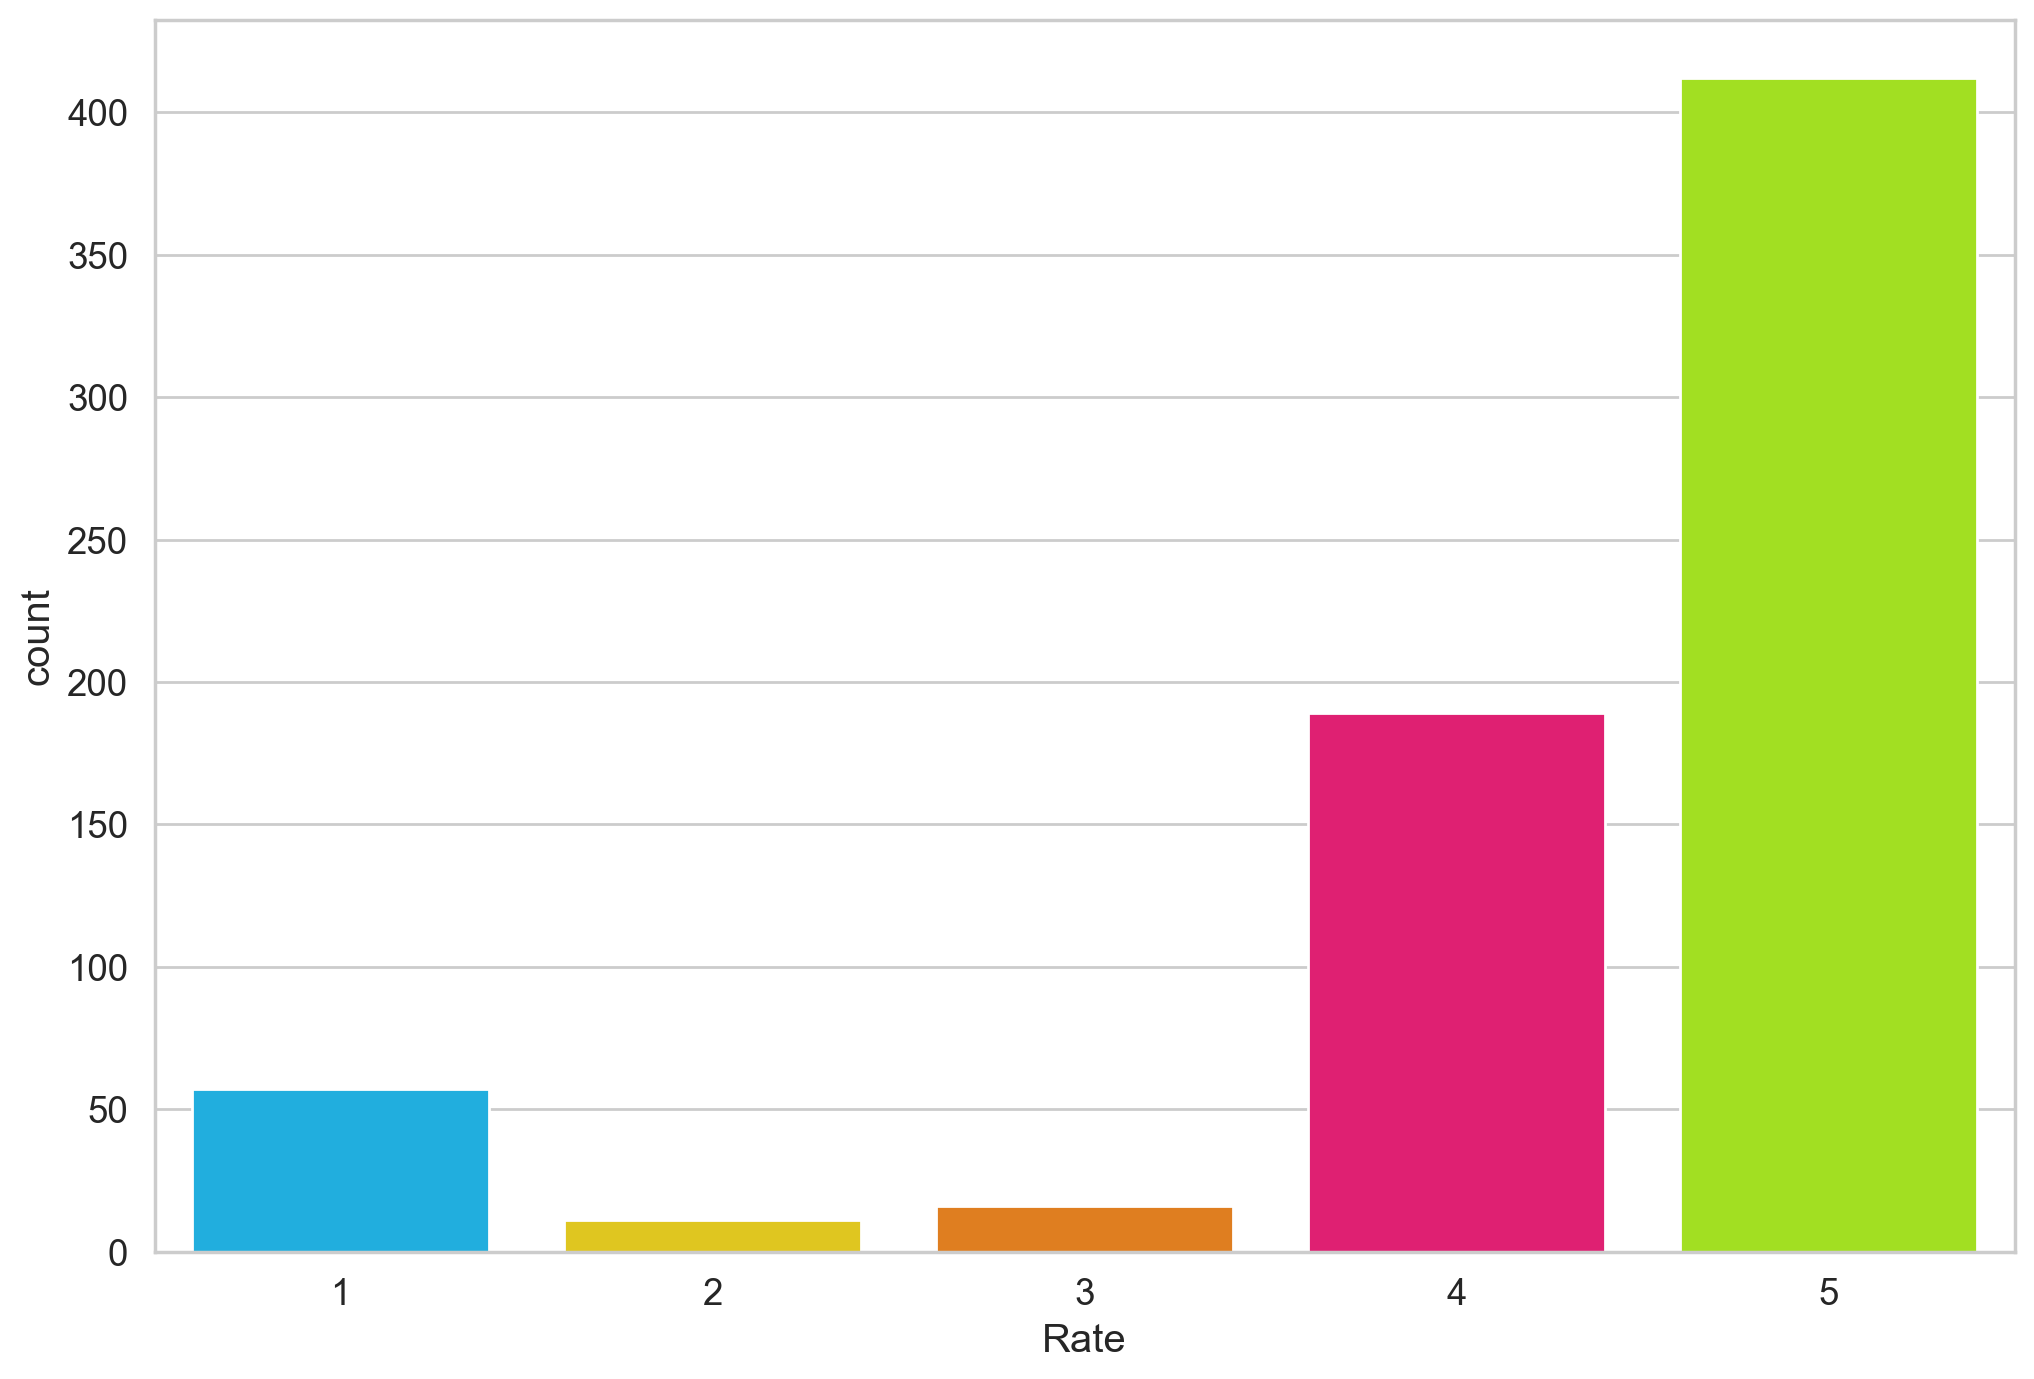

In [447]:
# visualize the review score
sns.countplot(x=df.Rate)
plt.xlabel('Rate')

In order to streamline result summarization and communication, while concurrently minimizing response ambiguity and promoting response consistency across diverse participants, I have discretely categorized the 'Rate' scale ['1','2','3','4','5'] into three distinct classifications: ['negative', 'neutral', and 'positive']

For sentiment label 'negative', the rating include 1 & 2;  
For sentiment label 'neutral', the rating include 3;  
For sentiment label 'positive', the rating include 4 & 5;

In [463]:
class_names = ['negative', 'neutral', 'positive']

def to_sentiment(Rate):
  Rate = int(Rate)
  if Rate <= 2:
    return 0
  elif Rate == 3:
    return 1
  elif Rate >= 4:
    return 2

df['Sentiment'] = df.Rate.apply(to_sentiment)

#### Data Visualization - Sentiment

[Text(0, 0, 'negative'), Text(1, 0, 'neutral'), Text(2, 0, 'positive')]

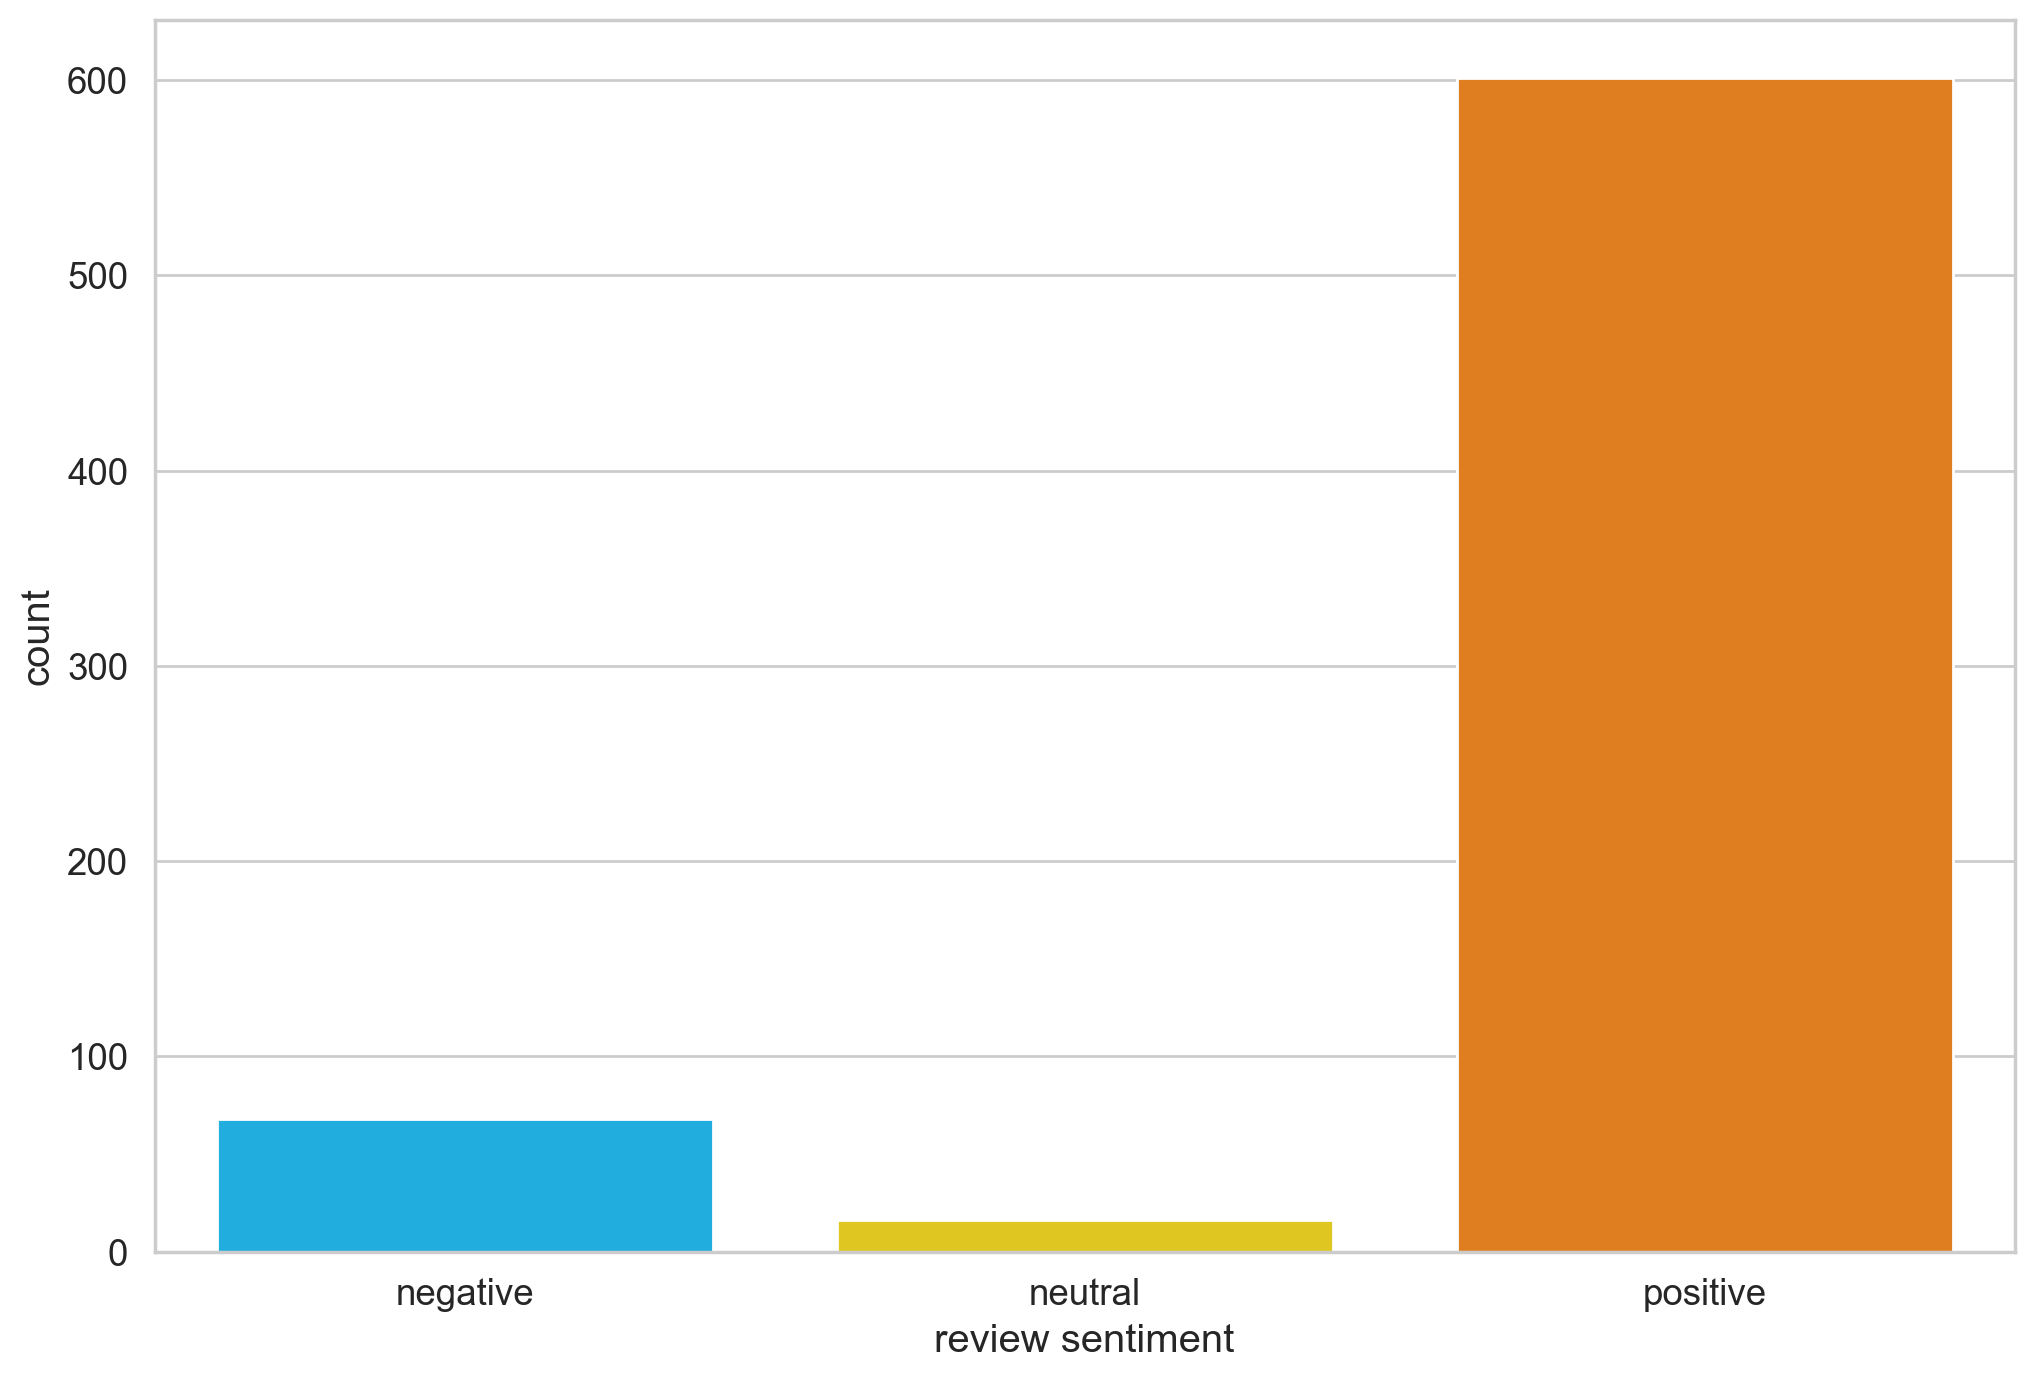

In [465]:
# visualize the review score
ax = sns.countplot(x=df.Sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names)

## Data Preprocessing

In [453]:
# Using bert-base-cased because all capitalized letter will show stronger tone in terms of customer review
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

#### Special Token

In [466]:
tokenizer.sep_token, tokenizer.sep_token_id
tokenizer.cls_token, tokenizer.cls_token_id
tokenizer.pad_token, tokenizer.pad_token_id
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

#### Sequence Length

In [467]:
token_lens = []

for txt in df.Summary:
  tokens = tokenizer.encode(txt, max_length=512, truncation=True) # without padding; padding=False
  token_lens.append(len(tokens))

C:\Users\Victoria\AppData\Local\Temp\ipykernel_10188\990217764.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)  # or use sns.histplot()


Text(0.5, 0, 'Token count')

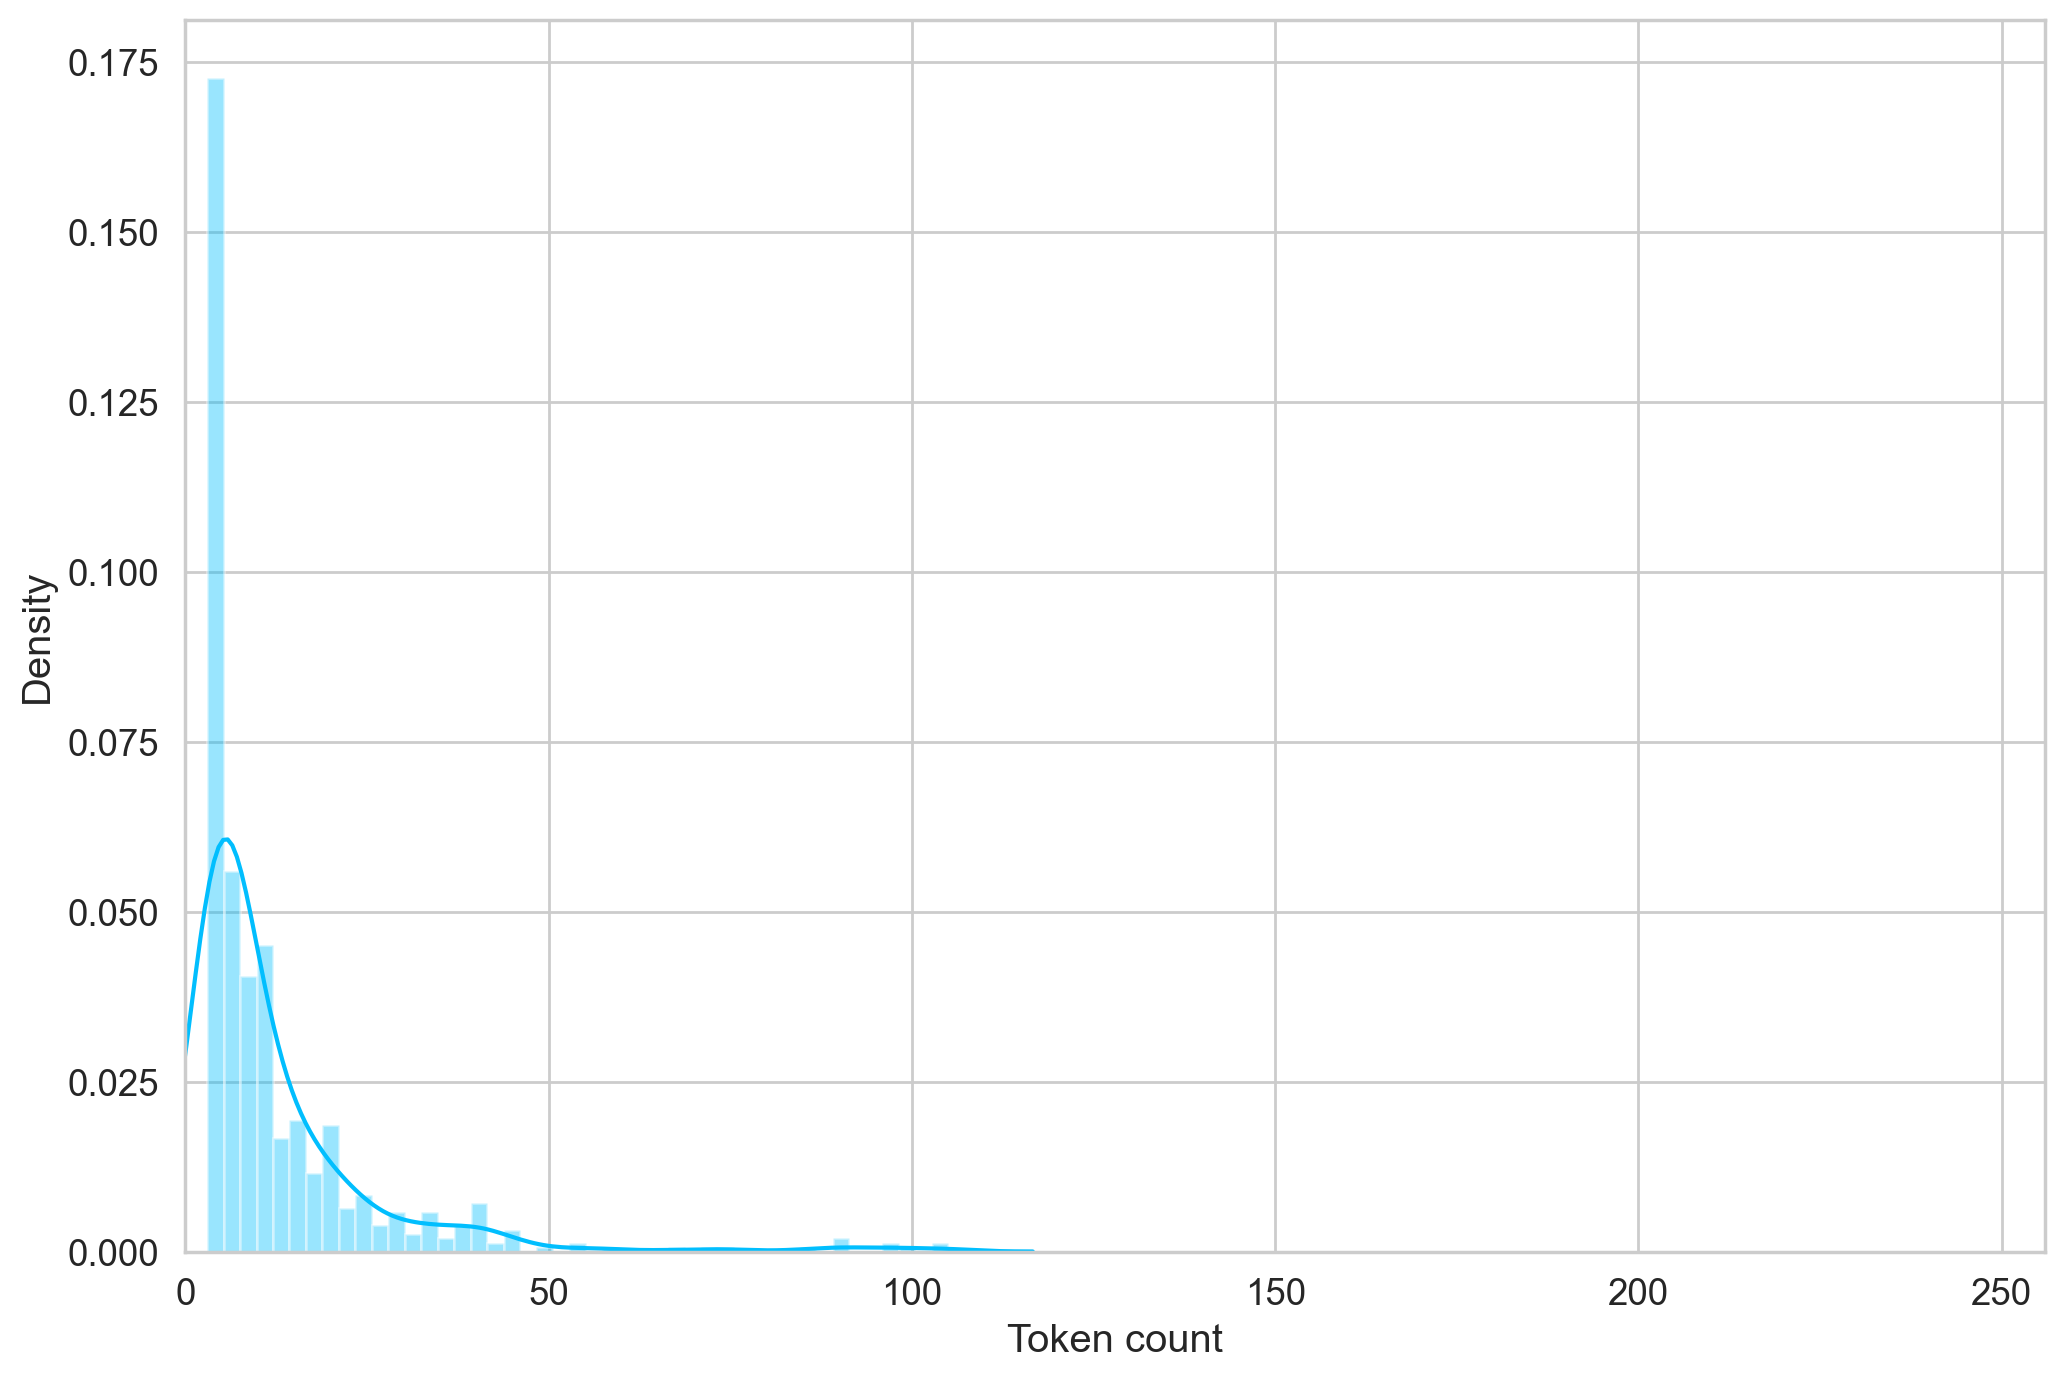

In [468]:
sns.distplot(token_lens)  # or use sns.histplot()
plt.xlim([0, 256])
plt.xlabel('Token count')

Based on the graph, most of the reviews show less than 50 token count

In [469]:
MAX_LEN = 50

####  Create Pytorch Dataset

In [470]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews    # df.Summary
    self.targets = targets    # df.Rate
    self.tokenizer = tokenizer
    self.max_len = max_len    # 50
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])    # E.g., "the best poduct that i bought from flifkart it works superb like ac and price is also reasonable only rs 8698"
    target = self.targets[item]       # E.g., sentiment - 5 (positive - rate 5)
    

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      truncation=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

#### Split Train and Test Set

In [472]:
df_train, df_test = train_test_split(df, test_size=0.3, random_state = RANDOM_SEED, stratify = df['Sentiment'])
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state = RANDOM_SEED, stratify = df_test['Sentiment'])

In [473]:
sorted_value_counts_df = pd.DataFrame({
    'df': df['Sentiment'].value_counts().sort_index(ascending=True),
    'df_train': df_train['Sentiment'].value_counts().sort_index(ascending=True),
    'df_test': df_test['Sentiment'].value_counts().sort_index(ascending=True),
    'df_val': df_val['Sentiment'].value_counts().sort_index(ascending=True)
})

sorted_value_counts_df

,df,df_train,df_test,df_val
Sentiment,,,,
0,68,48,10,10
1,16,11,3,2
2,601,420,90,91


In [474]:
df_train.shape, df_val.shape, df_test.shape

((479, 4), (103, 4), (103, 4))

In [475]:
def create_data_loader(df, tokenizer, max_len, batch_size, shuffle = True):  # df is set to df_train, df_val, or df_test
  ds = GPReviewDataset(
    reviews=df.Summary.to_numpy(),
    targets=df.Sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len,
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    shuffle = shuffle,
    #num_workers=4 #  process hangs with num_workers=4
    num_workers=0  #  num_workers: how many subprocesses to use for data loading. 0 means that the data will be 
                   #  loaded in the main process. (default: 0)
  )


In [476]:
BATCH_SIZE = 8 #16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

data = next(iter(train_data_loader))  # first batch from train data
data.keys()

print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([8, 50])
torch.Size([8, 50])
torch.Size([8])


## Sentiment Classification with BERT and Hugging Face

In [477]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [478]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)  # E.g., hidden_size: 768, n_classes: 3
  
  def forward(self, input_ids, attention_mask):
    outputs = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(outputs.pooler_output)
    return self.out(output)

In [479]:
model = SentimentClassifier(len(class_names))   # class_names is the list consist of the label

input_ids = data['input_ids']           # data contains the first batch of train data
attention_mask = data['attention_mask']

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([8, 50])
torch.Size([8, 50])


In [480]:
F.softmax(model(input_ids, attention_mask), dim=1)  # apply to the model without training

tensor([[0.4065, 0.4389, 0.1546],
        [0.3979, 0.4220, 0.1802],
        [0.3650, 0.3474, 0.2876],
        [0.3969, 0.2725, 0.3306],
        [0.3766, 0.4495, 0.1739],
        [0.6784, 0.2088, 0.1128],
        [0.4204, 0.4303, 0.1493],
        [0.5483, 0.3775, 0.0742]], grad_fn=<SoftmaxBackward0>)

Here, the tensor shows a shape (8,3), 8 represents the number of batch, 3 is the number of labels

## Training

In [485]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=1e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS       # number of batches in training data * epochs

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss()

In [486]:
def train_epoch(model, data_loader, loss_fn, optimizer, scheduler, n_examples):  # with training data
  
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"]
    attention_mask = d["attention_mask"]
    targets = d["targets"]

    outputs = model(input_ids=input_ids, attention_mask=attention_mask)

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)   # Clips gradients of an iterable of parameters.
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  print('finish data loader')
  return correct_predictions.double() / n_examples, np.mean(losses)

In [487]:
def eval_model(model, data_loader, loss_fn, n_examples):   # with validation data
  
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"]
      attention_mask = d["attention_mask"]
      targets = d["targets"]

      outputs = model(input_ids=input_ids, attention_mask=attention_mask)
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)


In [488]:
%%time

history = defaultdict(list)
best_accuracy = 0


for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(model, train_data_loader, loss_fn, optimizer, scheduler, len(df_train))

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(model, val_data_loader, loss_fn, len(df_val))

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc.cpu().detach().numpy())
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc.cpu().detach().numpy())
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc


Epoch 1/10
----------
finish data loader
Train loss 0.16658218958812843 accuracy 0.9603340292275574
Val   loss 0.35250647996256773 accuracy 0.9320388349514563

Epoch 2/10
----------
finish data loader
Train loss 0.08265409437784305 accuracy 0.9728601252609603
Val   loss 0.2537987462173288 accuracy 0.941747572815534

Epoch 3/10
----------
finish data loader
Train loss 0.03153797063569073 accuracy 0.9832985386221295
Val   loss 0.37322998941537944 accuracy 0.9320388349514563

Epoch 4/10
----------
finish data loader
Train loss 0.014623867595946648 accuracy 0.9958246346555324
Val   loss 0.2570612214247096 accuracy 0.9611650485436893

Epoch 5/10
----------
finish data loader
Train loss 0.005273986830070498 accuracy 1.0
Val   loss 0.3183000409833487 accuracy 0.941747572815534

Epoch 6/10
----------
finish data loader
Train loss 0.0008328994814898275 accuracy 1.0
Val   loss 0.33934615654876465 accuracy 0.941747572815534

Epoch 7/10
----------
finish data loader
Train loss 0.000531548586271431

(0.0, 1.0)

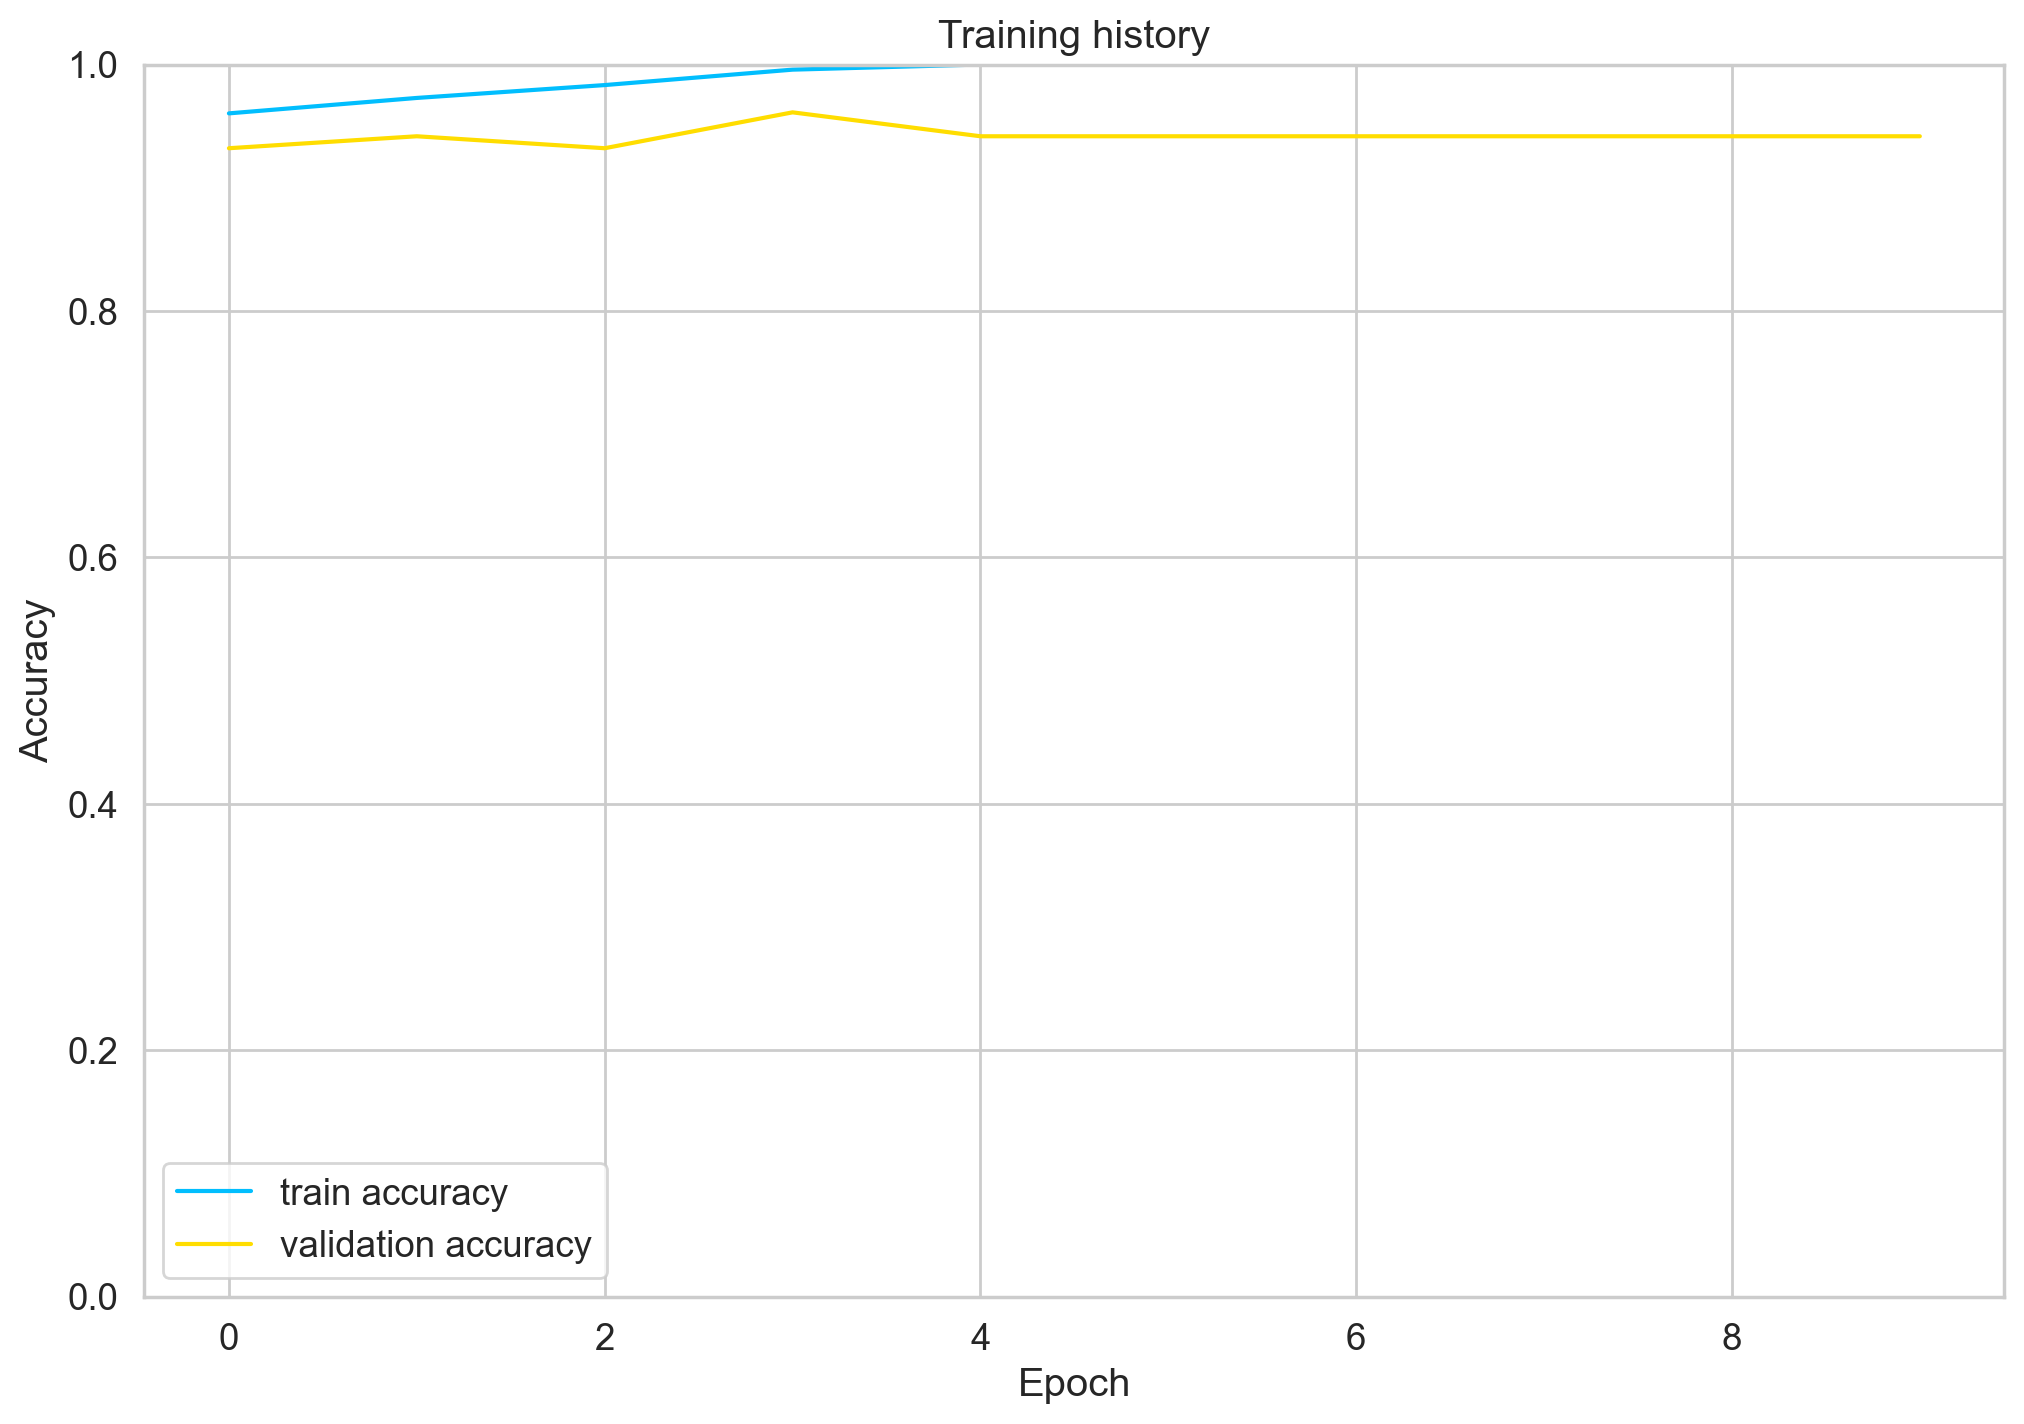

In [489]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])

## Evaluation

In [490]:
test_acc, _ = eval_model(model, test_data_loader, loss_fn, len(df_test))

test_acc.item()

0.9514563106796117

In [491]:
def get_predictions(model, data_loader):
  
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"]
      attention_mask = d["attention_mask"]
      targets = d["targets"]

      outputs = model(input_ids=input_ids, attention_mask=attention_mask)
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()   # E.g., prediction_probs.shape: (788, 3)
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [505]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model, test_data_loader)

In [493]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.71      1.00      0.83        10
     neutral       0.00      0.00      0.00         3
    positive       0.99      0.98      0.98        90

    accuracy                           0.95       103
   macro avg       0.57      0.66      0.61       103
weighted avg       0.93      0.95      0.94       103



c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##### Confusion Matrix

In [494]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment')

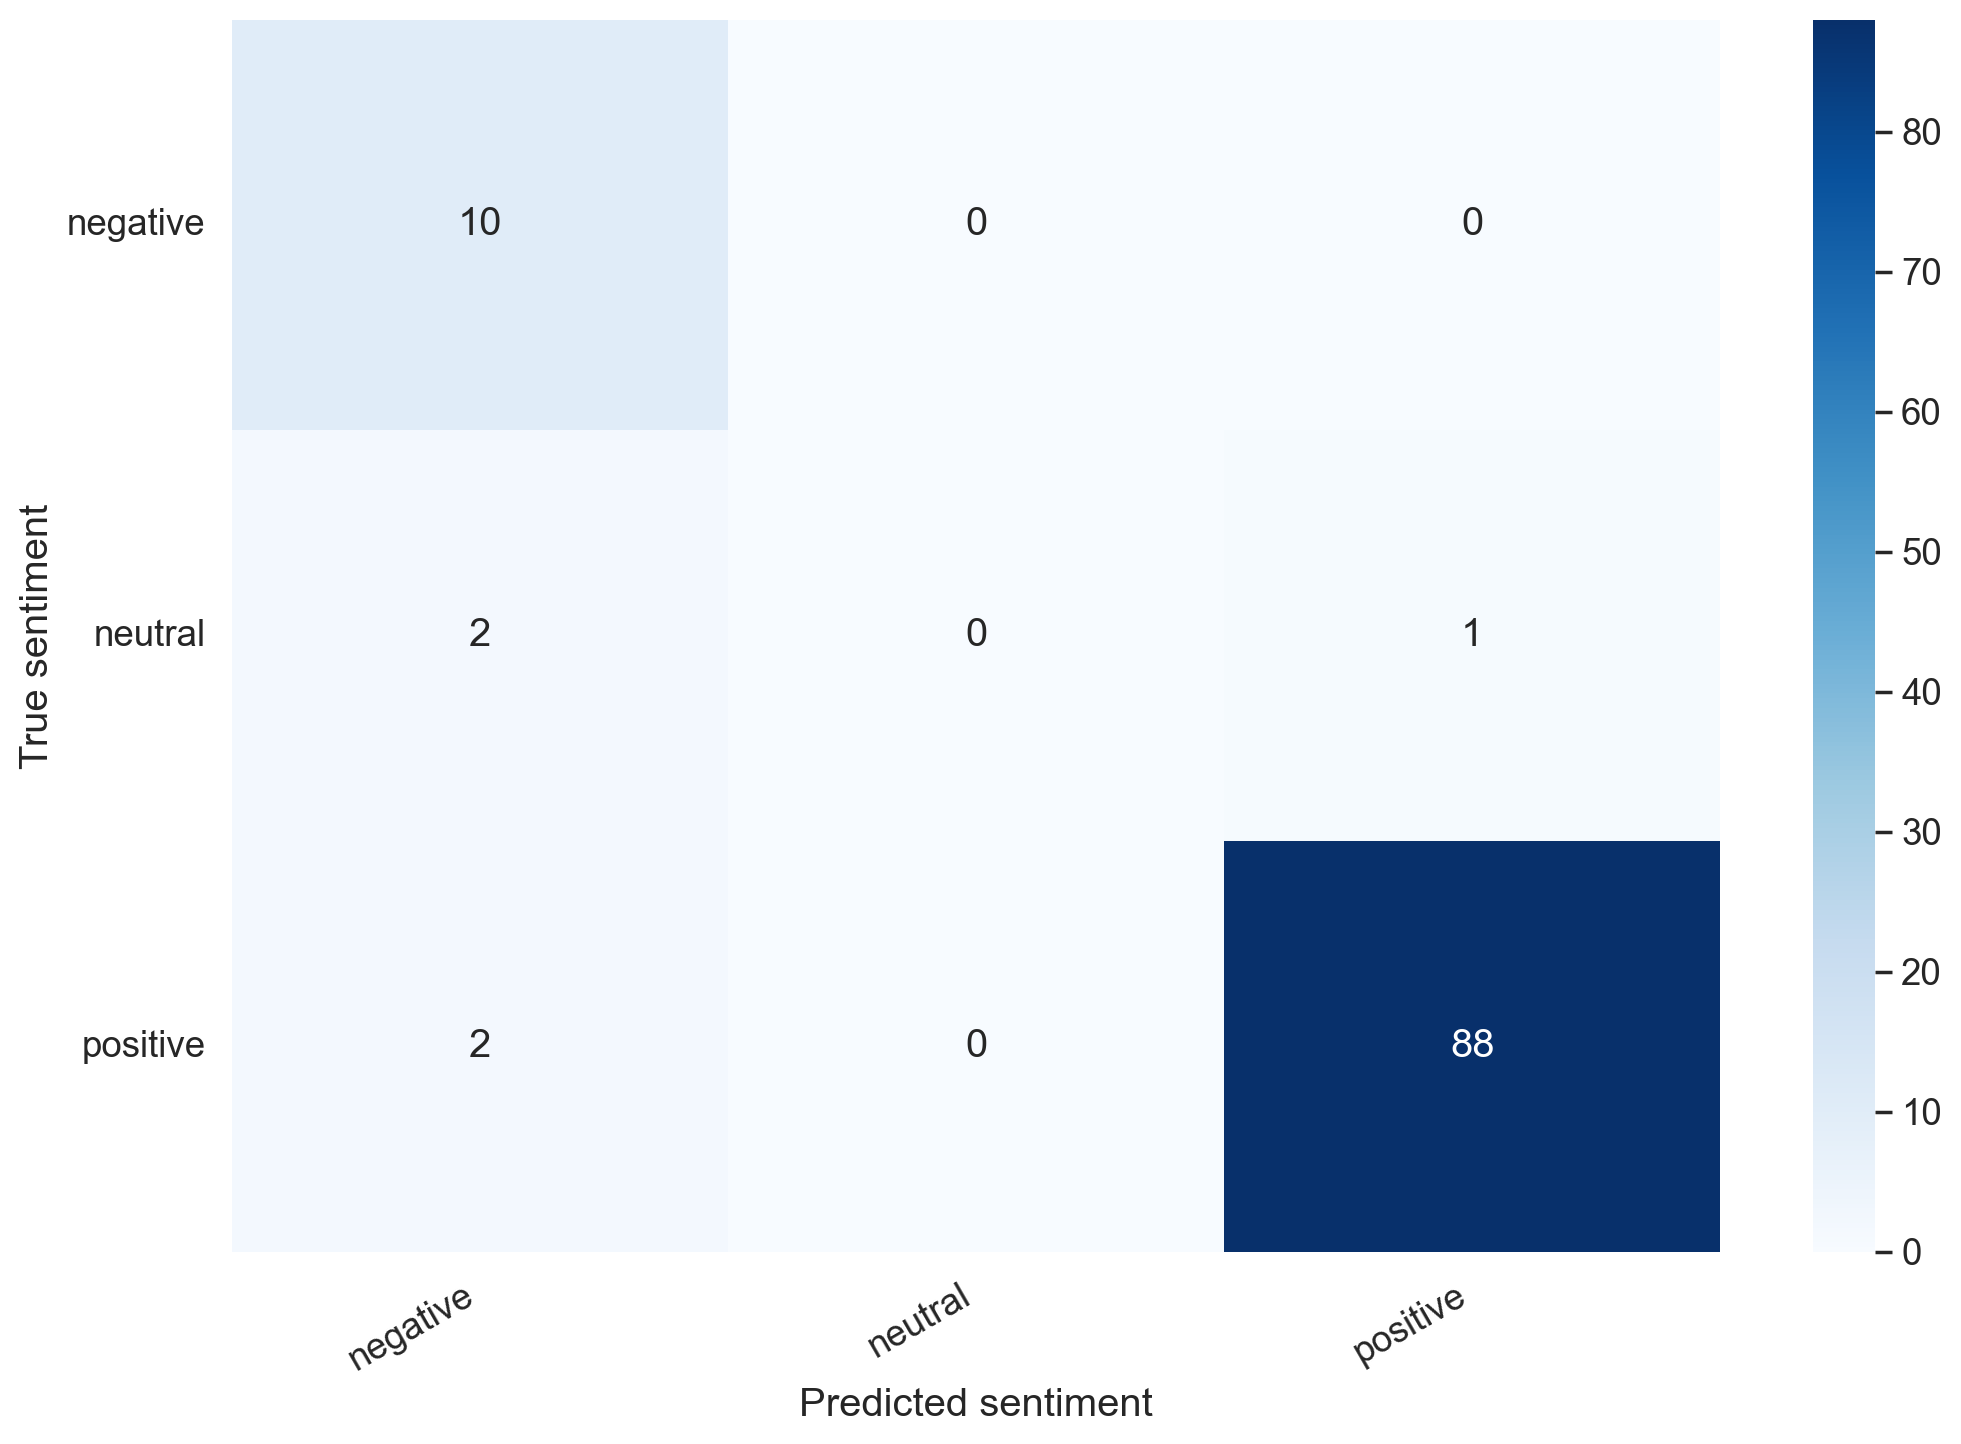

In [495]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [503]:
idx = 2

review_text = y_review_texts[idx]     # review text in test data
true_sentiment = y_test[idx]          # true sentiment
pred_df = pd.DataFrame({
  'class_names': class_names,         # class_names = ['negative', 'neutral', 'positive']
  'values': y_pred_probs[idx]         #         E.g., [0.05, 0.9, 0.05]
})

print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

nice products

True sentiment: positive


(0.0, 1.0)

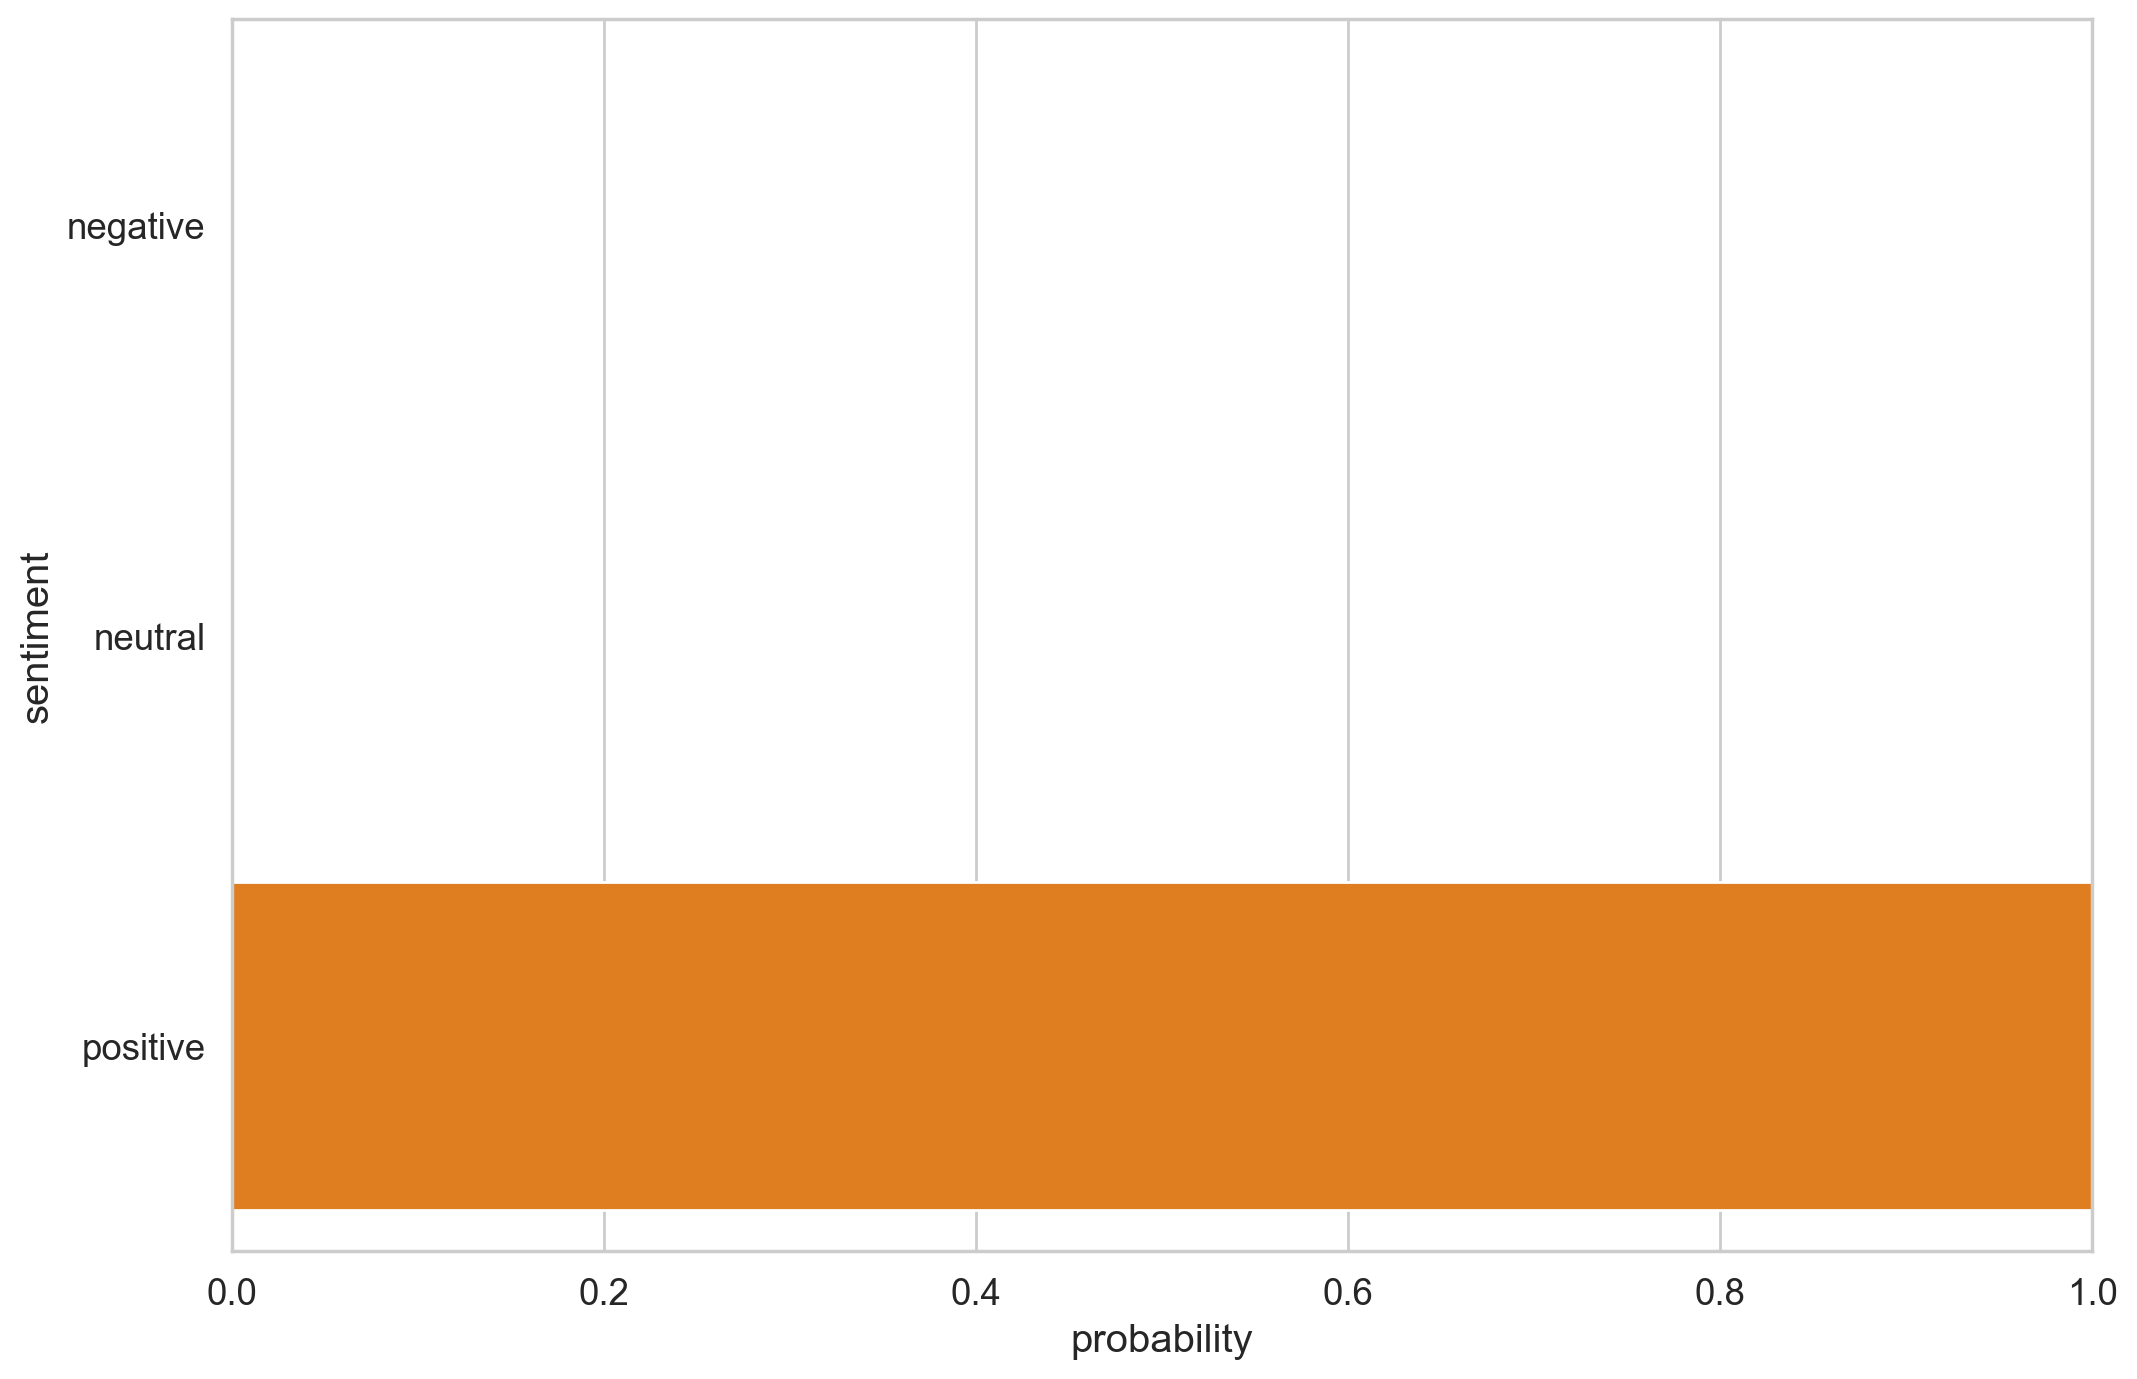

In [504]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1])